## The Fiddler: Can You Survive Another Squid Game?
[July 21, 2023](https://thefiddler.substack.com/p/can-you-survive-another-squid-game?utm_source=post-email-title&publication_id=1745947&post_id=135320907&isFreemail=true&utm_medium=email) <br> My first attempt at a Fiddler since the move!

### The Fiddler
This week, the final 20 players in the Squid Game competition form a circle and are assigned the whole numbers from 1 to 20, progressing in a clockwise direction. First, contestant 2 is eliminated. Then, the contestant two positions clockwise from where 2 was (i.e., contestant 4) is eliminated. Next, the contestant two positions clockwise from them (i.e., contestant 6) is eliminated. The counting continues in this manner, wrapping around the circle, which tightens after each elimination. So after contestant 20 is eliminated, the next contestant to go is 3, who at this point is two positions clockwise from where 20 once stood.

You repeat this process until only one contestant remains as the ultimate winner of the game. What is the winner’s number?

#### Solution

Solving this on paper just crossing numbers off one-by-one I arrived at <b>contestant 9</b> as the winner. Let's douoble check with a quick python script.

In [39]:
contestants = [i for i in range(1,21)]
print(contestants)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [40]:
eliminated = [] #array will hold the eliminated contestants
i=1 #the first contestant to go is #2 in position 1 in my array
while len(contestants) > 1:
    elim = contestants.pop(i) #remove the eliminated contestant
    eliminated.append(elim) #add to eliminated array
    #by popping the eliminated contestant, the len of the array decreases by 1 so we effectively
    #shift by 1 position with the pop, then add 1 to get to the overall 2 position shift required
    #finally, the index must be modulo the length of the remaining array to handle the wrap around
    i = (i+1) % len(contestants)
print(contestants, eliminated)

[9] [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 3, 7, 11, 15, 19, 5, 13, 1, 17]


The python loop gave the same winner and order of eliminations that I got by hand! Contestant 9 is the winner!

### Extra Credit
Instead of always proceeding two positions clockwise for each elimination, you now proceed two or three positions clockwise. That is, for each turn, you randomly (and independently of the other turns) pick either two or three positions to move, each with a 50 percent probability. No longer is number 2 guaranteed to be the first contestant eliminated—now numbers 2 and 3 are equally likely to be eliminated first.

Once again, you proceed clockwise around the circle, tightening it after each contestant is eliminated, until only one contestant remains. This time around, which number is most likely to win the game?

I'll approach this with a python loop that is analogous to the previous exercise. Instead of the index shift being fixed, there's a 50% chance of shifting by 2 or 3. I'll run a bunch of simulations, keeping track of how often each contestant wins, and see what the distribution looks like.

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [47]:
wins = np.zeros(20) #array will hold the number of wins for each position
trials = 1000000#number of simulations to run
for n in range(trials):
    contestants = [i for i in range(1,21)]
    #the first contestant to go is now 50% #2, 50% #3
    i = 1 if random.random() < 0.5 else 2
    while len(contestants) > 1:
        elim = contestants.pop(i)
        #the elimination index needs to shift by 2 or 3, each with 50% probability
        #as above, the pop handles one position shift so we need to add 1 or 2
        #then use the mod operator
        i = i+1 if random.random() < 0.5 else i+2
        i = i % len(contestants)
    wins[contestants[0] - 1] += 1 #add a win for the winner this time (index 0 = contestant 1)
print(wins/trials)

[0.062683 0.030314 0.030242 0.045448 0.030429 0.039297 0.039914 0.037809
 0.04359  0.04341  0.046354 0.05046  0.052698 0.056754 0.060173 0.063455
 0.066699 0.067659 0.06752  0.065092]


Now for some visualization.

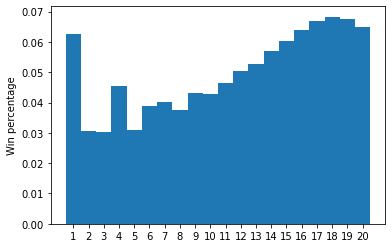

In [72]:
plt.hist([i for i in range(1,21)], weights=wins/trials, bins=[i-0.5 for i in range(1,22)])
plt.xticks(range(1,21))
plt.ylabel('Win percentage')
plt.show()

Looking at the histogram, a few characteristics stand out. Position 1 is good to be in, since constestant 1 survives the first loop around the circle no matter what (the first elimination is 2 or 3). Since 2 or 3 is the first contestant to go, these positions have low win probabilities. Contestant 4 is luckier than 2 and 3 (each with 50% chance of being eliminated immediately) and also 5. Contestant 4 is the second elimination 25% of the time (2+2), while 5 gets eliminated 50% of the time in round 2 (2+3 or 3+2). Further around the circle, win probabilities increase as the total number of potential paths of rotating by 2 or 3 positions increases. Positions 19 and 20 seem to have a lower probability than 18, getting closer to the contestant 1 probability. The exact reason for this turnaround is not immediately intuitive to me. Based on these 1,000,000 simulations I would say <b>contestant 18</b> is the most likely winner of this game.

##### Aside

I'd like to see if I can get there analytically as well, but don't think I currently have the time.

I know that after position $N$ is eliminated, the next elimination will be either position $N+2$ or $N+3$, each with 50% probability. Unfortunately, due to the changing size of the circle, the contestants 2 or 3 positions away are not necessarily the eliminated contestant's number plus 2 or 3, which makes things more complicated after the first full loop around the circle.

Some ideas that come to mind are to calculate the probability of survival for one loop given position and number of contestants. This would involve determining all paths of 2 or 3 steps around the circle and what percentage of those paths eliminate constestants in a given position. Then I could try some conditional probabilities to get through successive loops.

Another possible way through is to try usig just expected values. One contestant is eliminated every step so after N eliminations what's the expected size of the circle, how many loops have been completed, what's the expected position at step N, etc. This seems pretty promising, but I don't have the time to sit down today and think it through more carefully and would probably end up just simulating things to some extent anyway.

#### Back to simulations

I'll take a look at a few more properties/graphs.

First, what's the survival rate as a function of step or loop number for all contestants?

In [70]:
#steps (loops) array will give each contestant's survival rate after N eliminations (loops)
#by incrementing the i position in the contestant's row if they survive the ith elimination/loop
#since the number of loops is variable from game to game, the loops per game are also tracked
survival_steps = np.zeros((20,20)) 
survival_loops = np.zeros((21,20))
trials = 100000 #number of simulations to run
for n in range(trials):
    contestants = [i for i in range(1,21)]
    #the first contestant to go is now 50% #2, 50% #3
    i = 1 if random.random() < 0.5 else 2
    j = 1 #eliminations counter
    k = 1 #loops counter
    while len(contestants) > 1:
        contestants.pop(i)
        #the elimination index needs to shift by 2 or 3, each with 50% probability
        #as above, the pop handles one position shift so we need to add 1 or 2
        #then use the mod operator
        i = i+1 if random.random() < 0.5 else i+2
        #after each elimination check each contestant's survival
        for x in range(1,21):
            if x in contestants:
                survival_steps[x-1][j-1] += 1
        j += 1
        #check if a loop is done and calculate survivals if so
        if i >= len(contestants):
            for x in range(1,21):
                if x in contestants:
                    survival_loops[x-1][k-1] += 1
            survival_loops[20][k-1] += 1 #this game had a kth loop so increment array value
            k += 1
        i = i % len(contestants)
print(survival_steps)
print(survival_loops)

[[100000. 100000. 100000. 100000. 100000. 100000.  99235.  77568.  60894.
   59927.  59927.  58591.  43051.  36095.  35220.  24027.  20462.  12460.
    6247.      0.]
 [ 50241.  50241.  50241.  50241.  50241.  50241.  50241.  42089.  31090.
   30182.  30182.  29933.  22683.  18238.  17877.  12281.  10344.   6104.
    3076.      0.]
 [ 49759.  49759.  49759.  49759.  49759.  49759.  49759.  47090.  33417.
   29948.  29903.  29885.  24912.  18378.  17867.  13019.  10517.   6028.
    3042.      0.]
 [100000.  75051.  75051.  75051.  75051.  75051.  75051.  71992.  51493.
   45165.  45070.  45039.  38234.  27685.  26831.  19753.  15748.   9008.
    4449.      0.]
 [100000.  50066.  50066.  50066.  50066.  50066.  50066.  49698.  38754.
   30345.  29852.  29852.  27181.  18918.  17831.  14050.  10637.   6071.
    2950.      0.]
 [100000.  74883.  62298.  62298.  62298.  62298.  62298.  62298.  53151.
   38684.  37392.  37392.  35518.  24503.  22492.  18554.  13438.   7779.
    3848.      0.

In [71]:
for i in range(20):
    print(i+1,survival_steps[i][18]/trials)

1 0.06247
2 0.03076
3 0.03042
4 0.04449
5 0.0295
6 0.03848
7 0.04014
8 0.03802
9 0.04305
10 0.04446
11 0.04588
12 0.0504
13 0.05285
14 0.05836
15 0.06111
16 0.06312
17 0.06688
18 0.06735
19 0.06698
20 0.06528


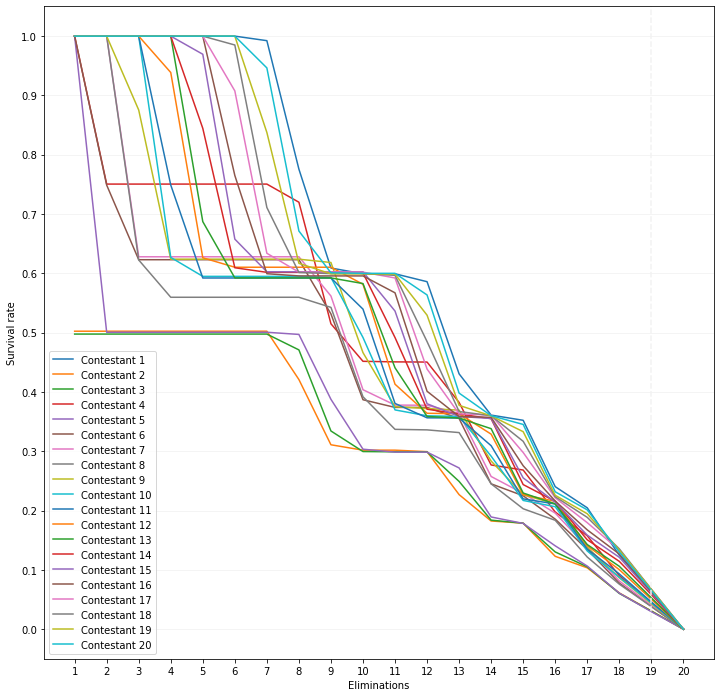

In [72]:
fig, ax = plt.subplots(figsize=(12,12))
for i in range(20):
    ax.plot(range(1,21), survival_steps[i]/trials, label='Contestant '+str(i+1))
plt.legend()
plt.xticks(range(1,21))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('Eliminations')
plt.ylabel('Survival rate')
plt.grid(axis='y', color='0.95')
plt.axvline(19, color='0.95', linestyle='--')
plt.show()

Looking at the above plot, we can see how each contestant's survival rate decreases as the number of eliminations increases. Contestant 1 cannot be eliminated until we go around the circle once so the Contestant 1 line graph stays at 1 (100% survival) until elimination 6 or 7. Conversely, Constestants 2 and 3 have a 50/50 chance of being the first elimination so their graphs start at 0.5 for 1 elimination. Half of the time, Contestant 5 is the next elimination, so at elimination 2, Contestant 5 only has 50% survival rate. The graphs all converge at a small value since as we have seen, all the contestants have a 3-7% chance of surviving 19 other eliminations (dashed vertical line). After 20 eliminations, all contestants would be eliminated, so the graphs all go to 0.

Less crowded plot and zoomed into later eliminations below:

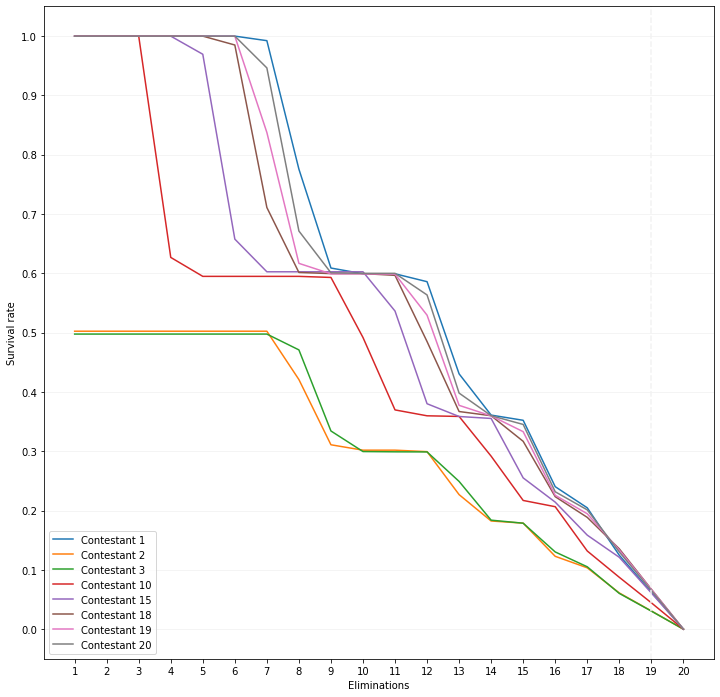

In [73]:
fig, ax = plt.subplots(figsize=(12,12))
for i in [0,1,2,9,14,17,18,19]:
    ax.plot(range(1,21), survival_steps[i]/trials, label='Contestant '+str(i+1))
plt.legend()
plt.xticks(range(1,21))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('Eliminations')
plt.ylabel('Survival rate')
plt.grid(axis='y', color='0.95')
plt.axvline(19, color='0.95', linestyle='--')
plt.show()

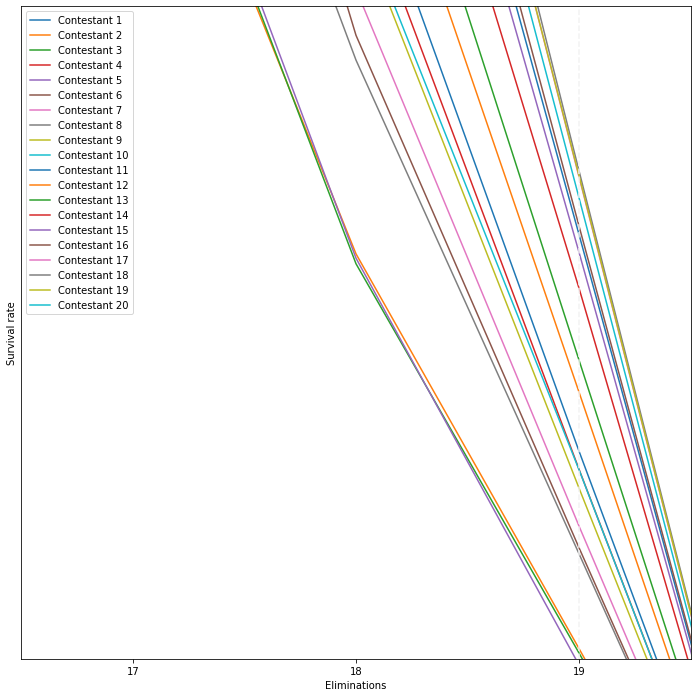

In [75]:
fig, ax = plt.subplots(figsize=(12,12))
for i in range(20):
    ax.plot(range(1,21), survival_steps[i]/trials, label='Contestant '+str(i+1))
plt.legend()
plt.xticks(range(1,21))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('Eliminations')
plt.ylabel('Survival rate')
plt.grid(axis='y', color='0.95')
plt.axvline(19, color='0.95', linestyle='--')
plt.axis([16.5,19.5,0.03,0.08])
plt.show()

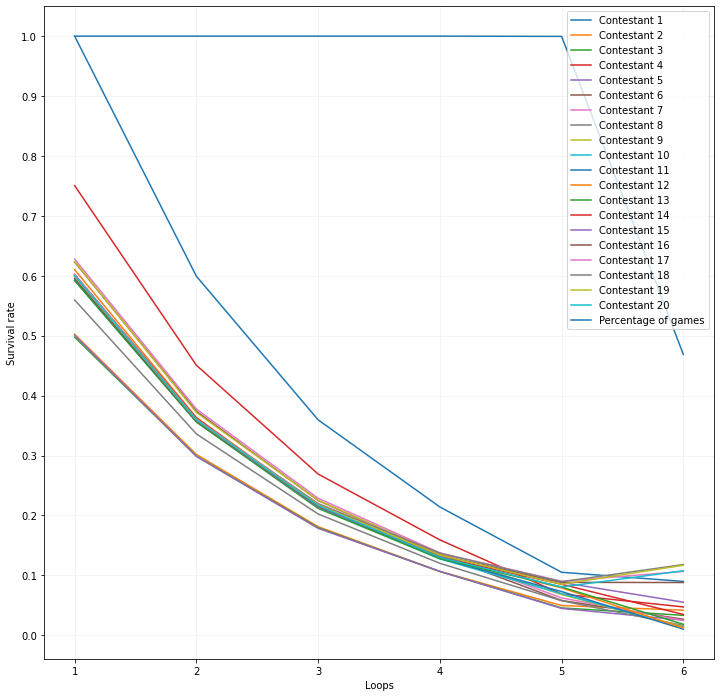

In [76]:
fig, ax = plt.subplots(figsize=(12,12))
for i in range(20):
    ax.plot(range(1,7), survival_loops[i][:6]/survival_loops[20][:6], label='Contestant '+str(i+1))
ax.plot(range(1,7), survival_loops[20][:6]/trials, label='Percentage of games')
plt.legend()
plt.xticks(range(1,7))
plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('Loops')
plt.ylabel('Survival rate')
plt.grid(axis='y', color='0.95')
plt.grid(axis='x', color='0.95')
plt.show()

Looking at this plot, we can see survival rate as a function of the number of loops completed. Again since Contestant 1 is never eliminated until we get around the circle once, their survival rate is 100% for 1 loop. Contestant 4 only loses with steps of 2+2, which happens 1 in 4 times, so their survival is 75%. Interestingly, Contestant 1 is better off through all loops until we get to a 6 loop game, when their advantage is no longer present. No games reached a full 7th loop, but just under 50% of games completed 6 loops and ended during that 7th time around, while just over 50% had 5 full loops and finished before finishing the 6th. Contestant 1 does better in those games than end before 6 full loops, while the other contestants like 18 benefit from getting another loop in.

Note: The denominator here for survival rate is the total number of games with N complete loops. This doesn't necessarily need to decrease, as seen in a few graphs going from 5 to 6. As a percentage of all 6 loop games, some contestants survive a higher percentage of those games compared to the percentage of all 5 loop games they surive. In other words, both the numerator and denominators change for each point on the graphs. The numerators decrease with increasing x since you can only surive N+1 loops by survivng N loops already, but the denominator decreases as well as N loop games become more rare for larger N. So if the denominator decreases by a larger relative amount than the numerator, this survival rate can increase. Games with 6 loops are rare, and contestants with high starting positions do better in these rarer games relative to 5 loop games.

What's the average position eliminated at step N? What does the distribution of positions look like at step N for a couple values of N?

In [86]:
avg_eliminated = np.zeros(20) #used to calculate average position of elimination for step N
elimination_dist = [[] for _ in range(20)] #used for full distribution of eliminations at step N
trials = 1000 #number of simulations to run
for n in range(trials):
    contestants = [i for i in range(1,21)]
    #the first contestant to go is now 50% #2, 50% #3
    i = 1 if random.random() < 0.5 else 2
    j = 1 #eliminations counter
    while len(contestants) > 1:
        elim = contestants.pop(i)
        #the elimination index needs to shift by 2 or 3, each with 50% probability
        #as above, the pop handles one position shift so we need to add 1 or 2
        #then use the mod operator
        i = i+1 if random.random() < 0.5 else i+2
        i = i % len(contestants)
        #add the contestant eliminated with each step
        avg_eliminated[j-1] += elim
        elimination_dist[j-1].append(elim)
        j += 1
print(avg_eliminated/trials)
for i in range(19):
    print(np.mean(elimination_dist[i]))

[ 2.509  5.002  7.488  9.981 12.484 14.977 17.283 12.881  5.308  7.391
 11.598 15.456 11.847  7.273 12.661 11.73  10.795 10.06  11.87   0.   ]
2.509
5.002
7.488
9.981
12.484
14.977
17.283
12.881
5.308
7.391
11.598
15.456
11.847
7.273
12.661
11.73
10.795
10.06
11.87


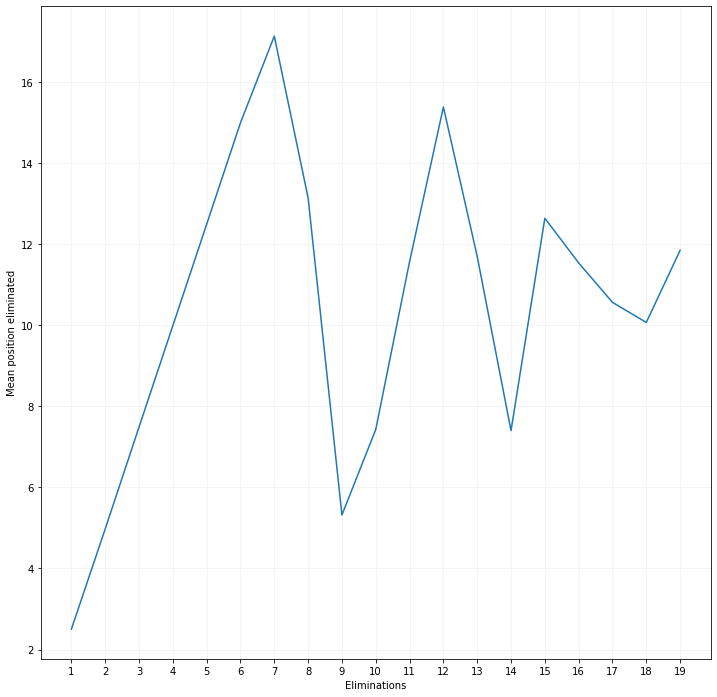

In [85]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(range(1,20), avg_eliminated[:19]/trials)
plt.xticks(range(1,20))
plt.xlabel('Eliminations')
plt.ylabel('Mean position eliminated')
plt.grid(axis='y', color='0.95')
plt.grid(axis='x', color='0.95')
plt.show()

The plot above shows the average elimination position as we progress through eliminations. We start between 2 and 3 and work through the circle before looping around back to the lower positions.

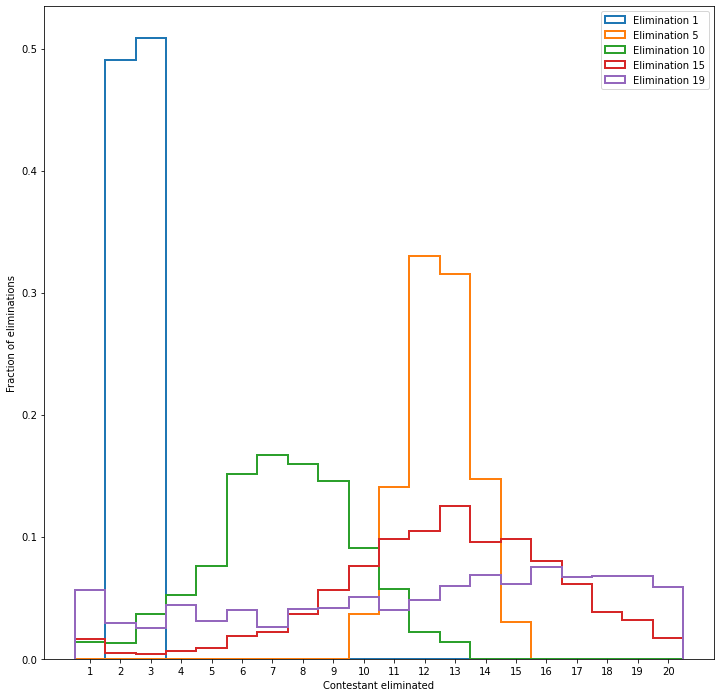

In [92]:
fig, ax = plt.subplots(figsize=(12,12))
for i in [1,5,10,15,19]:
    plt.hist(elimination_dist[i-1], bins=[i-0.5 for i in range(1,22)], 
             label='Elimination '+str(i), histtype='step', density=True, linewidth=2)    
plt.xticks(range(1,21))
plt.ylabel('Fraction of eliminations')
plt.xlabel('Contestant eliminated')
plt.legend()
plt.show()

In this last plot, we can see the full distributions that go into the previous averages for various eliminations. At elimination 1 we have (close to) 50/50 between Contetstants 2 and 3. By elimination 5 we have moved up to the higher number contestants, before wrapping back around by elimination 10 and so on. We also see that for higher number eliminations, due to the randomness and increasing number of possible paths, the distributions get wider. What started as a 50/50 2-bin disitrbution for elimination 1 gets wider until the final elimination is pretty close to a uniform distribution across all 20 contestants.